<h2 align=center>Analisis Data Box Office Global dengan Seaborn dan Python</h2>

Proyek ini adalah bagian dari eksplorasi dan analisis data box office film global. Dalam notebook ini, saya melakukan berbagai langkah pemrosesan data, eksplorasi, visualisasi menggunakan Seaborn dan Matplotlib, serta mungkin juga pengembangan model sederhana untuk memahami faktor-faktor yang mempengaruhi pendapatan film. Tujuan utamanya adalah untuk mendapatkan wawasan dari data dan mengidentifikasi tren atau pola yang relevan di industri film.

## Dataset

Dataset yang digunakan dalam proyek ini berisi data film dan informasi terkait, yang digunakan untuk membangun model prediksi pendapatan (`revenue`) berdasarkan berbagai fitur. Dataset tersedia dalam dua file: `train.csv` dan `test.csv`.

Dataset ini mencakup beberapa kolom penting berikut:

- **budget**  
  Jumlah anggaran produksi film dalam satuan dolar.

- **homepage**  
  Tautan ke situs resmi film (jika tersedia). Jika tidak ada, nilainya kosong.

- **original_language**  
  Bahasa asli yang digunakan dalam film .

- **original_title**  
  Judul asli film seperti yang tercatat saat perilisan.

- **overview**  
  Ringkasan singkat atau sinopsis cerita film.

- **revenue**  
  Pendapatan total yang diperoleh film dalam satuan dolar. Kolom ini merupakan target variabel yang akan diprediksi.


### Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Task 1: Pemanggilan dan Eksplorasi Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

### Task 2: Memvisualisasikan Distribusi Target

Text(0.5, 1.0, 'Distribution of log-transformed revenue')

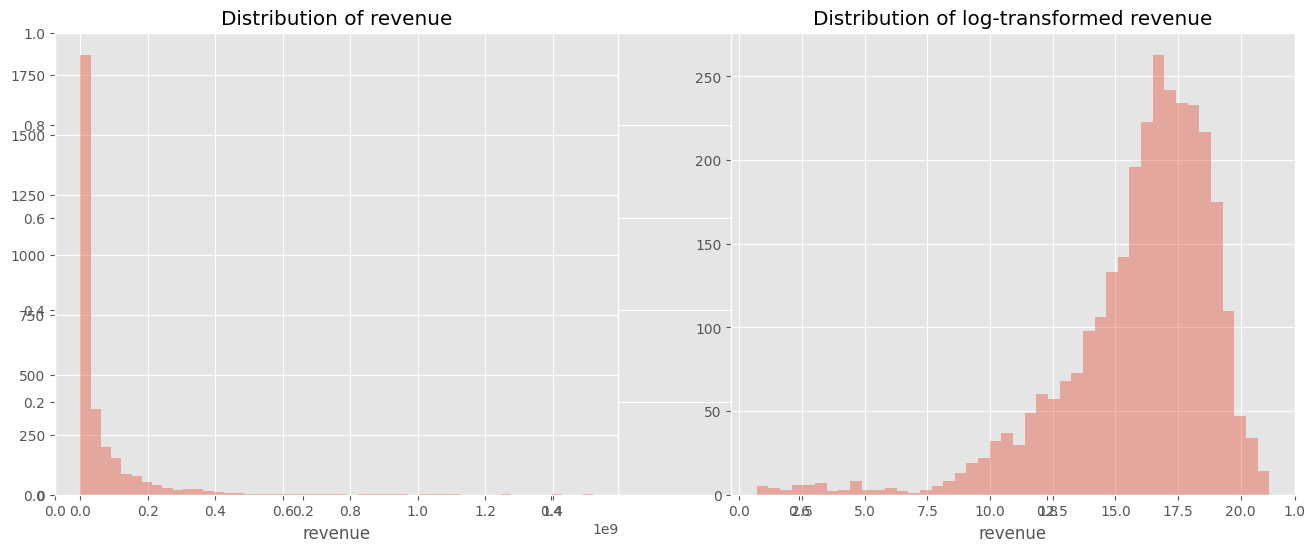

In [4]:
fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.distplot(train['revenue'], kde=False);
plt.title('Distribution of revenue')
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train['revenue']), kde=False);
plt.title('Distribution of log-transformed revenue')             

In [5]:
train['log_revenue'] = np.log1p(train['revenue'])

### Task 3: Hubungan antara Pendapatan Film dan Anggaran

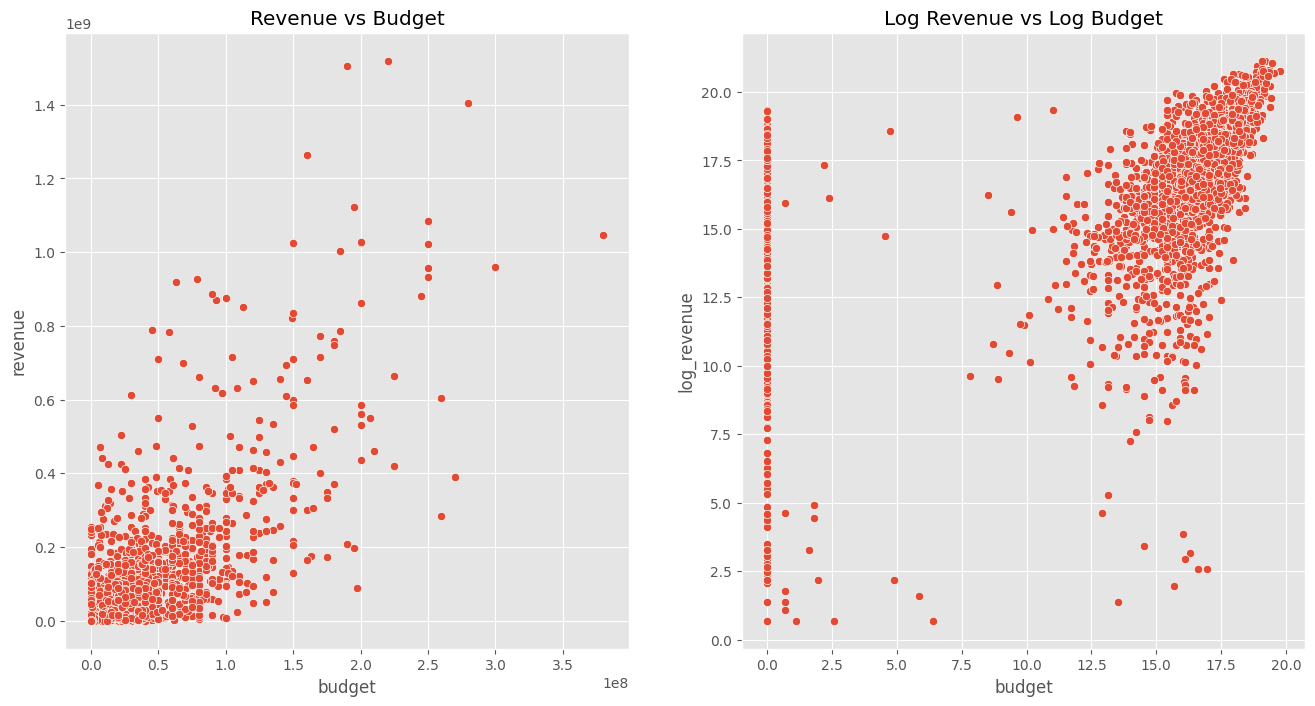

In [6]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x = train['budget'], y = train['revenue'])
plt.title('Revenue vs Budget');
plt.subplot(1, 2, 2)
sns.scatterplot(x = np.log1p(train['budget']), y = train['log_revenue'])
plt.title('Log Revenue vs Log Budget');

In [7]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

### Task 4: Apakah Memiliki Laman Resmi Mempengaruhi Pendapatan?

In [8]:
train['homepage'].value_counts().head(16)

homepage
http://www.transformersmovie.com/                      4
http://www.lordoftherings.net/                         2
http://www.thehobbit.com/                              2
http://www.maoslastdancermovie.com/                    1
http://sonyclassics.com/pariscanwait/                  1
http://www.maxpaynethemovie.com                        1
http://www.sonypictures.com/movies/afewgoodmen/        1
http://www.theasylum.cc/product.php?id=203             1
http://www.miramax.com/movie/the-cider-house-rules/    1
http://cropseylegend.com/                              1
http://www.nooneissafe.com                             1
http://www.magpictures.com/drinkingbuddies             1
https://www.facebook.com/BigGameMovie                  1
http://www.thewolverinemovie.com                       1
http://sh-sh.ru/                                       1
http://theovernight-movie.com/                         1
Name: count, dtype: int64

In [9]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

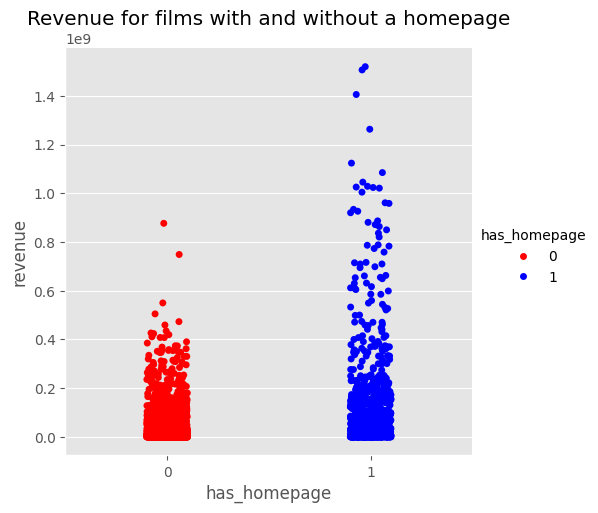

In [10]:
sns.catplot(x='has_homepage', y='revenue', hue='has_homepage', data=train, palette={0: 'red', 1: 'blue'}); 
plt.title('Revenue for films with and without a homepage');

### Task 5: Distribusi Bahasa dalam Film

In [11]:
language_data = train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]

Text(0.5, 1.0, 'Mean log revenue per language')

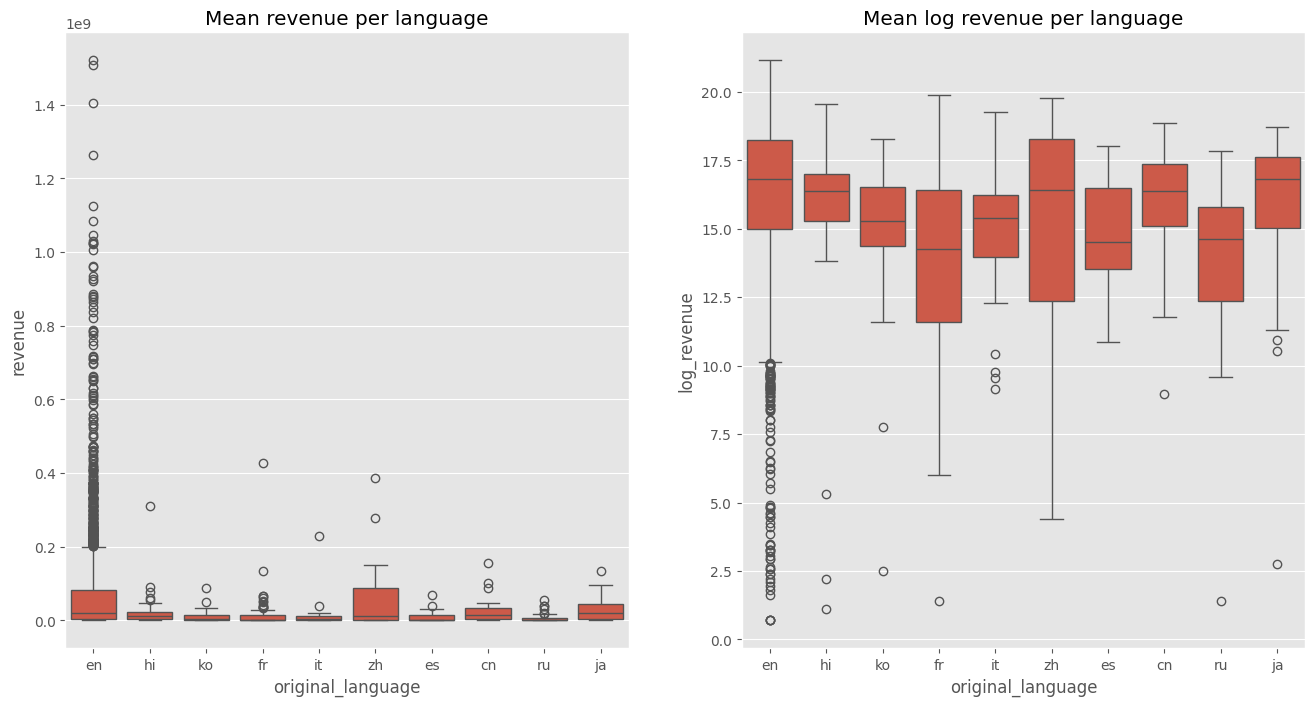

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=language_data)
plt.title('Mean revenue per language')
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=language_data)
plt.title('Mean log revenue per language')

### Task 6: Kata-kata yang Sering Muncul dalam Judul dan Deskripsi Film

### Pada Judul

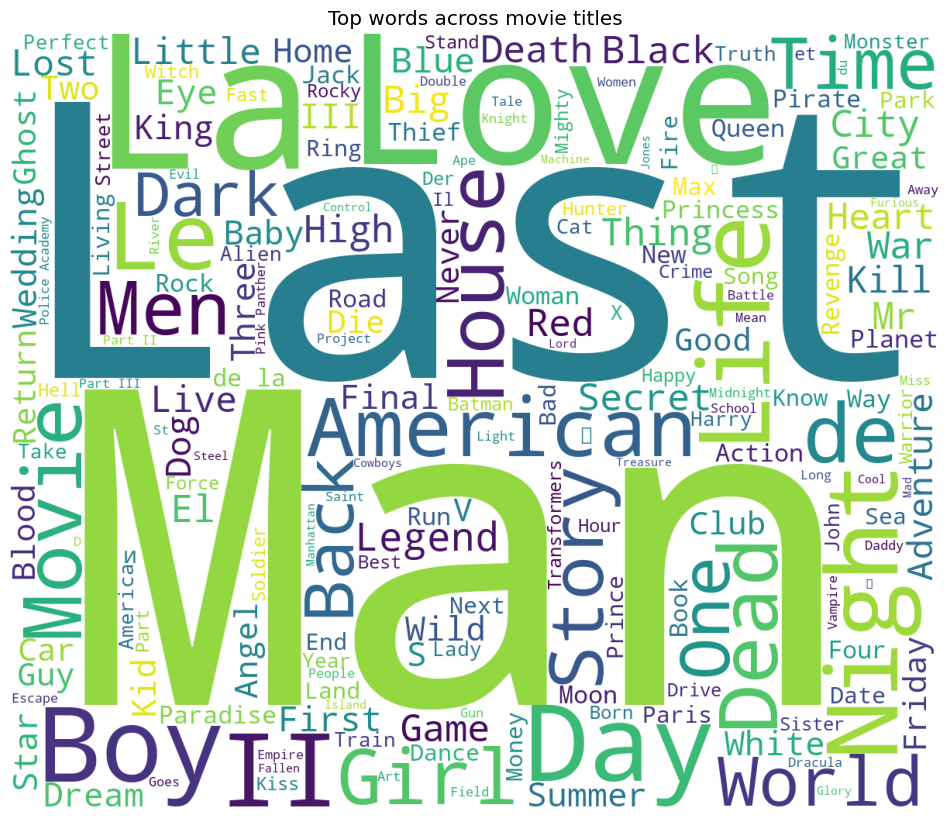

In [13]:
plt.figure(figsize=(12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None,
                      background_color='white',
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words across movie titles')
plt.axis('off')
plt.show()

### Pada Deskripsi

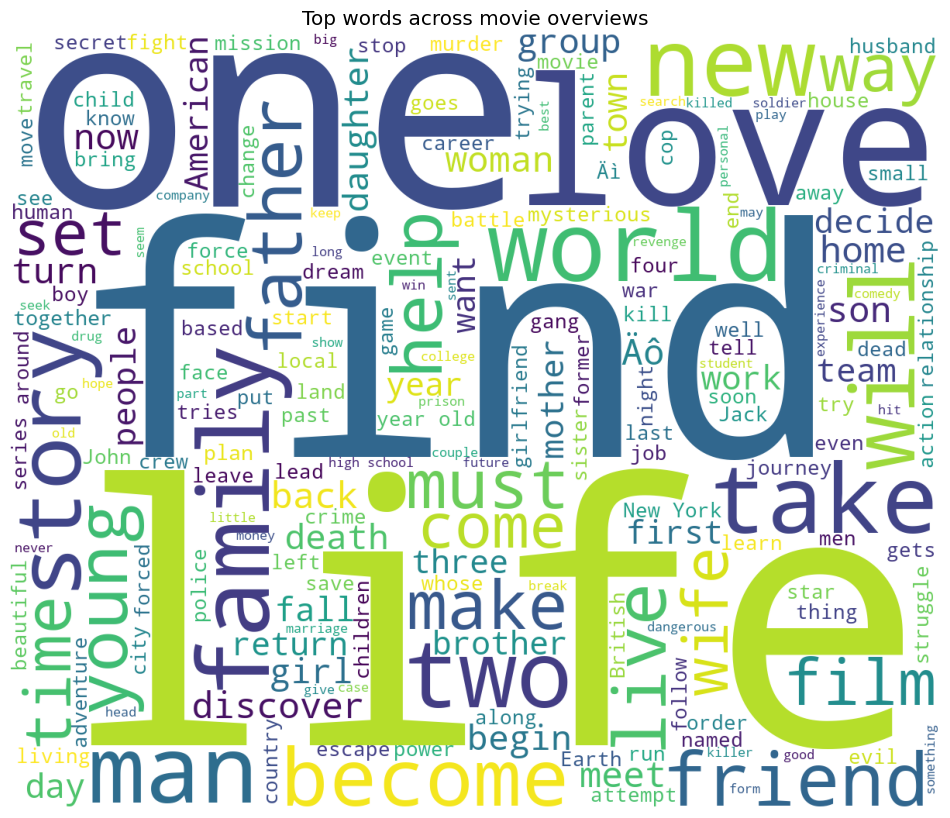

In [14]:
plt.figure(figsize=(12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None,
                      background_color='white',
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words across movie overviews')
plt.axis('off')
plt.show()

### Task 7: Apakah Deskripsi Film Mempengaruhi Pendapatan?

In [16]:
import eli5
from sklearn.linear_model import LinearRegression

In [22]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    min_df=5,
    stop_words='english' 
)


overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])

eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')